In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style("darkgrid")
from tqdm.notebook import tqdm
import scipy.stats as st
import random
from itertools import combinations
import statsmodels.stats.multitest as bon 
import os

seed = 1

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Load and preprocess data:

In [2]:
names = ['epoch', 'id', 'CTC_loss', 'WER', 'ref_WER_lens', 'hyp_WER_lens', 'CER', 'ref_CER_lens', 'hyp_CER_lens']
df_tc2 = pd.read_csv('tacotron2-cutvsdev-cleanY2021-m05-d07-H13-M43.csv', sep='\t', header=None, names=names)
df_base = pd.read_csv('test-clean-cutvsdev-cleanY2021-m05-d07-H13-M43.csv', sep='\t', header=None, names=names)
df_wavenet = pd.read_csv('wavenet-cutvsdev-cleanY2021-m05-d07-H13-M43.csv', sep='\t', header=None, names=names)
df_tc2_wavenet = pd.read_csv('wavenet-tacotron2vsdev-cleanY2021-m06-d08-H14-M05.csv', sep='\t', header=None, names=names)

def set_error_rates(df):
    df['max_WER_lens'] = df['ref_WER_lens']
    df['WER_rate'] = df['WER']/df['max_WER_lens']
    df['max_CER_lens'] = df['ref_CER_lens'] 
    df['CER_rate'] = df['CER']/df['max_CER_lens']
    
set_error_rates(df_tc2)
set_error_rates(df_base)
set_error_rates(df_wavenet)
set_error_rates(df_tc2_wavenet)

# Find the optimal epoch for each model from CTC loss 
df_tc2_epoch = df_tc2.groupby('epoch').mean()['CTC_loss']
df_wavenet_epoch = df_wavenet.groupby('epoch').mean()['CTC_loss']
df_base_epoch = df_base.groupby('epoch').mean()['CTC_loss']
df_tc2_wavenet_epoch = df_tc2_wavenet.groupby('epoch').mean()['CTC_loss']

tc2_epoch = df_tc2_epoch.argmin()
wavenet_epoch = df_wavenet_epoch.argmin()
base_epoch = df_base_epoch.argmin()
tc2_wavenet_epoch = df_tc2_wavenet_epoch.argmin()

print("Optimal Tacotron 2 epoch: {}".format(tc2_epoch))
print("Optimal BERT WaveNet epoch: {}".format(wavenet_epoch))
print("Optimal Mel-spectogram WaveNet epoch: {}".format(base_epoch))
print("Optimal Base epoch: {}".format(tc2_wavenet_epoch))

Optimal Tacotron 2 epoch: 13
Optimal BERT WaveNet epoch: 52
Optimal Mel-spectogram WaveNet epoch: 21
Optimal Base epoch: 71


In [3]:
# Example of data matrix:
df_wavenet

,epoch,id,CTC_loss,WER,ref_WER_lens,hyp_WER_lens,CER,ref_CER_lens,hyp_CER_lens,max_WER_lens,WER_rate,max_CER_lens,CER_rate
0,1,3853-163249-0012,715.077942,50,50,0,255,255,0,50,1.000000,255,1.000000
1,1,3853-163249-0042,572.026306,46,46,0,200,200,0,46,1.000000,200,1.000000
2,1,3853-163249-0052,548.793213,36,36,0,195,195,0,36,1.000000,195,1.000000
3,1,3853-163249-0017,558.689758,41,41,0,199,199,0,41,1.000000,199,1.000000
4,1,3853-163249-0014,509.629944,36,36,0,180,180,0,36,1.000000,180,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426082,158,1988-24833-0021,224.988815,14,15,12,52,77,43,15,0.933333,77,0.675325
426083,158,1988-24833-0001,369.975464,27,27,23,96,135,66,27,1.000000,135,0.711111
426084,158,1988-24833-0009,281.900696,19,20,18,71,97,61,20,0.950000,97,0.731959
426085,158,1988-24833-0017,295.664917,22,24,16,68,99,51,24,0.916667,99,0.686869


In [4]:
class _ColorHEX:
    def __init__(self):
        self.blue = "#1f77b4"
        self.orange = "#ff7f0e"
        self.green = "#2ca02c"
        self.red = "#d62728"
        self.purple = "#9467bd" 
        self.brown = "#8c564b"
        self.pink = "#e377c2"
        self.grey =  "#7f7f7f"
colors_hex = _ColorHEX()

# Permuation test:

In [6]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Get data for optimal epoch
pd_wavenet = df_wavenet.loc[df_wavenet['epoch'] == wavenet_epoch]
pd_tc2 = df_tc2.loc[df_tc2['epoch'] == tc2_epoch]
pd_base = df_base.loc[df_base['epoch'] == base_epoch]
pd_mel = df_base.loc[df_base['epoch'] == tc2_wavenet_epoch]

# Observe WER and CER (rates) 
pd_wavenet = pd_wavenet[['WER_rate','CER_rate']]
pd_tc2 = pd_tc2[['WER_rate','CER_rate']]
pd_base = pd_base[['WER_rate','CER_rate']]
pd_mel = pd_mel[['WER_rate','CER_rate']]

# Collect CER and Wer for the 4 models 
list1 = [pd_wavenet['WER_rate'], pd_tc2['WER_rate'], pd_base['WER_rate'], pd_mel['WER_rate']]
df_WER = pd.concat(list1,axis=1)

list2 = [pd_wavenet['CER_rate'], pd_tc2['CER_rate'], pd_base['CER_rate'], pd_mel['CER_rate']]
df_CER = pd.concat(list2,axis=1)

def permutation_test(data1, data2):
    permutations = 10000
    
    # Calulate observed permutation statistic
    t_obs = data1.mean()-data2.mean()
    
    # Save t_0 distribution of permutation statistic samples 
    t_vals = np.zeros(permutations)
    
    # 1000 random permutations (with frozen transcript group)
    for k in range(permutations):
        perm = np.random.choice(a=[False, True], size=len(data1))
        
        group1 = perm*data1+np.logical_not(perm)*data2
        group2 = np.logical_not(perm)*data1+perm*data2
        
        s = group1.mean()-group2.mean()
        t_vals[k] = s
    
    # Calculate p-value
    logic_vector = np.logical_or(t_vals >= abs(t_obs), t_vals <= -abs(t_obs))
    pval = np.mean(logic_vector)
        
    return t_obs, t_vals, pval
        
# Permutation tests on WER
t_obs1, t_vals1, p1 = permutation_test(df_WER.iloc[:,0],df_WER.iloc[:,1])
t_obs2, t_vals2, p2 = permutation_test(df_WER.iloc[:,0],df_WER.iloc[:,2])
t_obs3, t_vals3, p3 = permutation_test(df_WER.iloc[:,0],df_WER.iloc[:,3])
t_obs4, t_vals4, p4 = permutation_test(df_WER.iloc[:,1],df_WER.iloc[:,2])
t_obs5, t_vals5, p5 = permutation_test(df_WER.iloc[:,1],df_WER.iloc[:,3])
t_obs6, t_vals6, p6 = permutation_test(df_WER.iloc[:,2],df_WER.iloc[:,3])

# Permutation tests on CER
t_obs7, t_vals7, p7 = permutation_test(df_CER.iloc[:,0],df_WER.iloc[:,1])
t_obs8, t_vals8, p8 = permutation_test(df_CER.iloc[:,0],df_WER.iloc[:,2])
t_obs9, t_vals9, p9 = permutation_test(df_CER.iloc[:,0],df_WER.iloc[:,3])
t_obs10, t_vals10, p10 = permutation_test(df_CER.iloc[:,1],df_WER.iloc[:,2])
t_obs11, t_vals11, p11 = permutation_test(df_CER.iloc[:,1],df_WER.iloc[:,3])
t_obs12, t_vals12, p12 = permutation_test(df_CER.iloc[:,2],df_WER.iloc[:,3])

# Bonferroni correct p-values 
pvals1 = bon.multipletests([p1,p2,p3,p4,p5,p6],alpha=0.05,method="bonferroni")[1]
pvals2 = bon.multipletests([p7,p8,p9,p10,p11,p12],alpha=0.05,method="bonferroni")[1]

In [7]:
for i in range(6):
    print("p-value {}: {}".format(i,pvals1[i]))
for i in range(6):
    print("p-value {}: {}".format(i,pvals2[i]))

p-value 0: 0.0
p-value 1: 0.0
p-value 2: 0.0
p-value 3: 0.0
p-value 4: 0.0
p-value 5: 0.0
p-value 0: 0.0
p-value 1: 0.0
p-value 2: 0.0
p-value 3: 0.0
p-value 4: 0.0
p-value 5: 0.0


# Two-sample non-parameteric bootstrapping:

In [8]:
# Set random seed 
random.seed(1)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Significance level
numb_comparisons = 6
sign_level = 0.05/numb_comparisons 

# Calculate statistics 
mapping = {"Taco": df_tc2.loc[ df_tc2.epoch == tc2_epoch, "WER_rate"],
           "Base": df_base.loc[ df_base.epoch == base_epoch, "WER_rate"],
           "Wavenet": df_wavenet.loc[ df_wavenet.epoch == wavenet_epoch, "WER_rate"],
           "Taco_Wavenet": df_tc2_wavenet.loc[ df_tc2_wavenet.epoch == tc2_wavenet_epoch, "WER_rate"]}

possible_combinations = list(iter(combinations(["Taco", "Base", "Wavenet", "Taco_Wavenet"], 2)))
triplets = []

for i, pair in enumerate(possible_combinations):
    print(pair)
    for model_a, model_b in [pair]:
        wer_a, wer_b = mapping[model_a].reset_index(drop=True), mapping[model_b].reset_index(drop=True)
        diff = wer_a - wer_b
        print(f"{model_a}-{model_b}")
        data = [ diff.sample(2703, replace=True).mean() for _ in range(1000) ]
        triplet = np.quantile(data, sign_level/2), np.mean(data), np.quantile(data, 1 - sign_level/2)
        triplets.append(triplet)
        print( [ round(t,5) for t in triplet] )  

('Taco', 'Base')
Taco-Base
[-0.03167, -0.0239, -0.01673]
('Taco', 'Wavenet')
Taco-Wavenet
[-0.1136, -0.10269, -0.09219]
('Taco', 'Taco_Wavenet')
Taco-Taco_Wavenet
[-0.14496, -0.13117, -0.11893]
('Base', 'Wavenet')
Base-Wavenet
[-0.08842, -0.07882, -0.06885]
('Base', 'Taco_Wavenet')
Base-Taco_Wavenet
[-0.12063, -0.10718, -0.09554]
('Wavenet', 'Taco_Wavenet')
Wavenet-Taco_Wavenet
[-0.0365, -0.02809, -0.01934]


# One-sample non-parametric bootstrapping:

Helper function:

In [9]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

def extract_file_extension(file_name:str):
    """
    >>> extract_file_extensions("some_path/works_with_backslashes\\and_2x_extensions.tar.gz")
    '.tar.gz'
    """
    assert file_name.find(".") != -1, "No ´.´ found"
    suffixes = pathlib.Path(file_name).suffixes
    return ''.join(pathlib.Path(file_name).suffixes)

def save_plt_plot(save_path, fig=None, dpi=300):
    assert extract_file_extension(save_path) in [".png", ".jpg", ".pdf"]
    if fig is None:
        plt.savefig(save_path, dpi = dpi, bbox_inches = 'tight')
    else:
        fig.savefig(save_path, dpi = dpi, bbox_inches = 'tight')

class _ColorHEX:
    def __init__(self):
        self.blue = "#1f77b4"
        self.orange = "#ff7f0e"
        self.green = "#2ca02c"
        self.red = "#d62728"
        self.purple = "#9467bd" 
        self.brown = "#8c564b"
        self.pink = "#e377c2"
        self.grey =  "#7f7f7f"
colors_hex = _ColorHEX()

WER one-sample non-parametric bootstrapping confidence intervals for all epochs:

In [10]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Bootstrap
df =  pd.DataFrame( np.ones((147*4, 4)), columns=["model_type", "mean", "low", "high"])
i = 0

for epoch in tqdm(range(1, 147)):
    mapping = {"Tacotron": df_tc2.loc[ df_tc2.epoch == epoch, "WER_rate"],
               "Baseline": df_base.loc[ df_base.epoch == epoch, "WER_rate"],
               "WaveNet": df_wavenet.loc[ df_wavenet.epoch == epoch, "WER_rate"],
               "Tacotron+Wavenet": df_tc2_wavenet.loc[ df_tc2_wavenet.epoch == epoch, "WER_rate"]}
    
    for model in list(mapping.keys()):
        wer = mapping[model]
        data = [ wer.sample(2703, replace=True).mean() for _ in range(1000) ]
        df.iloc[i] = model, np.mean(data), np.quantile(data, 0.025), np.quantile(data, 0.975)
        i += 1

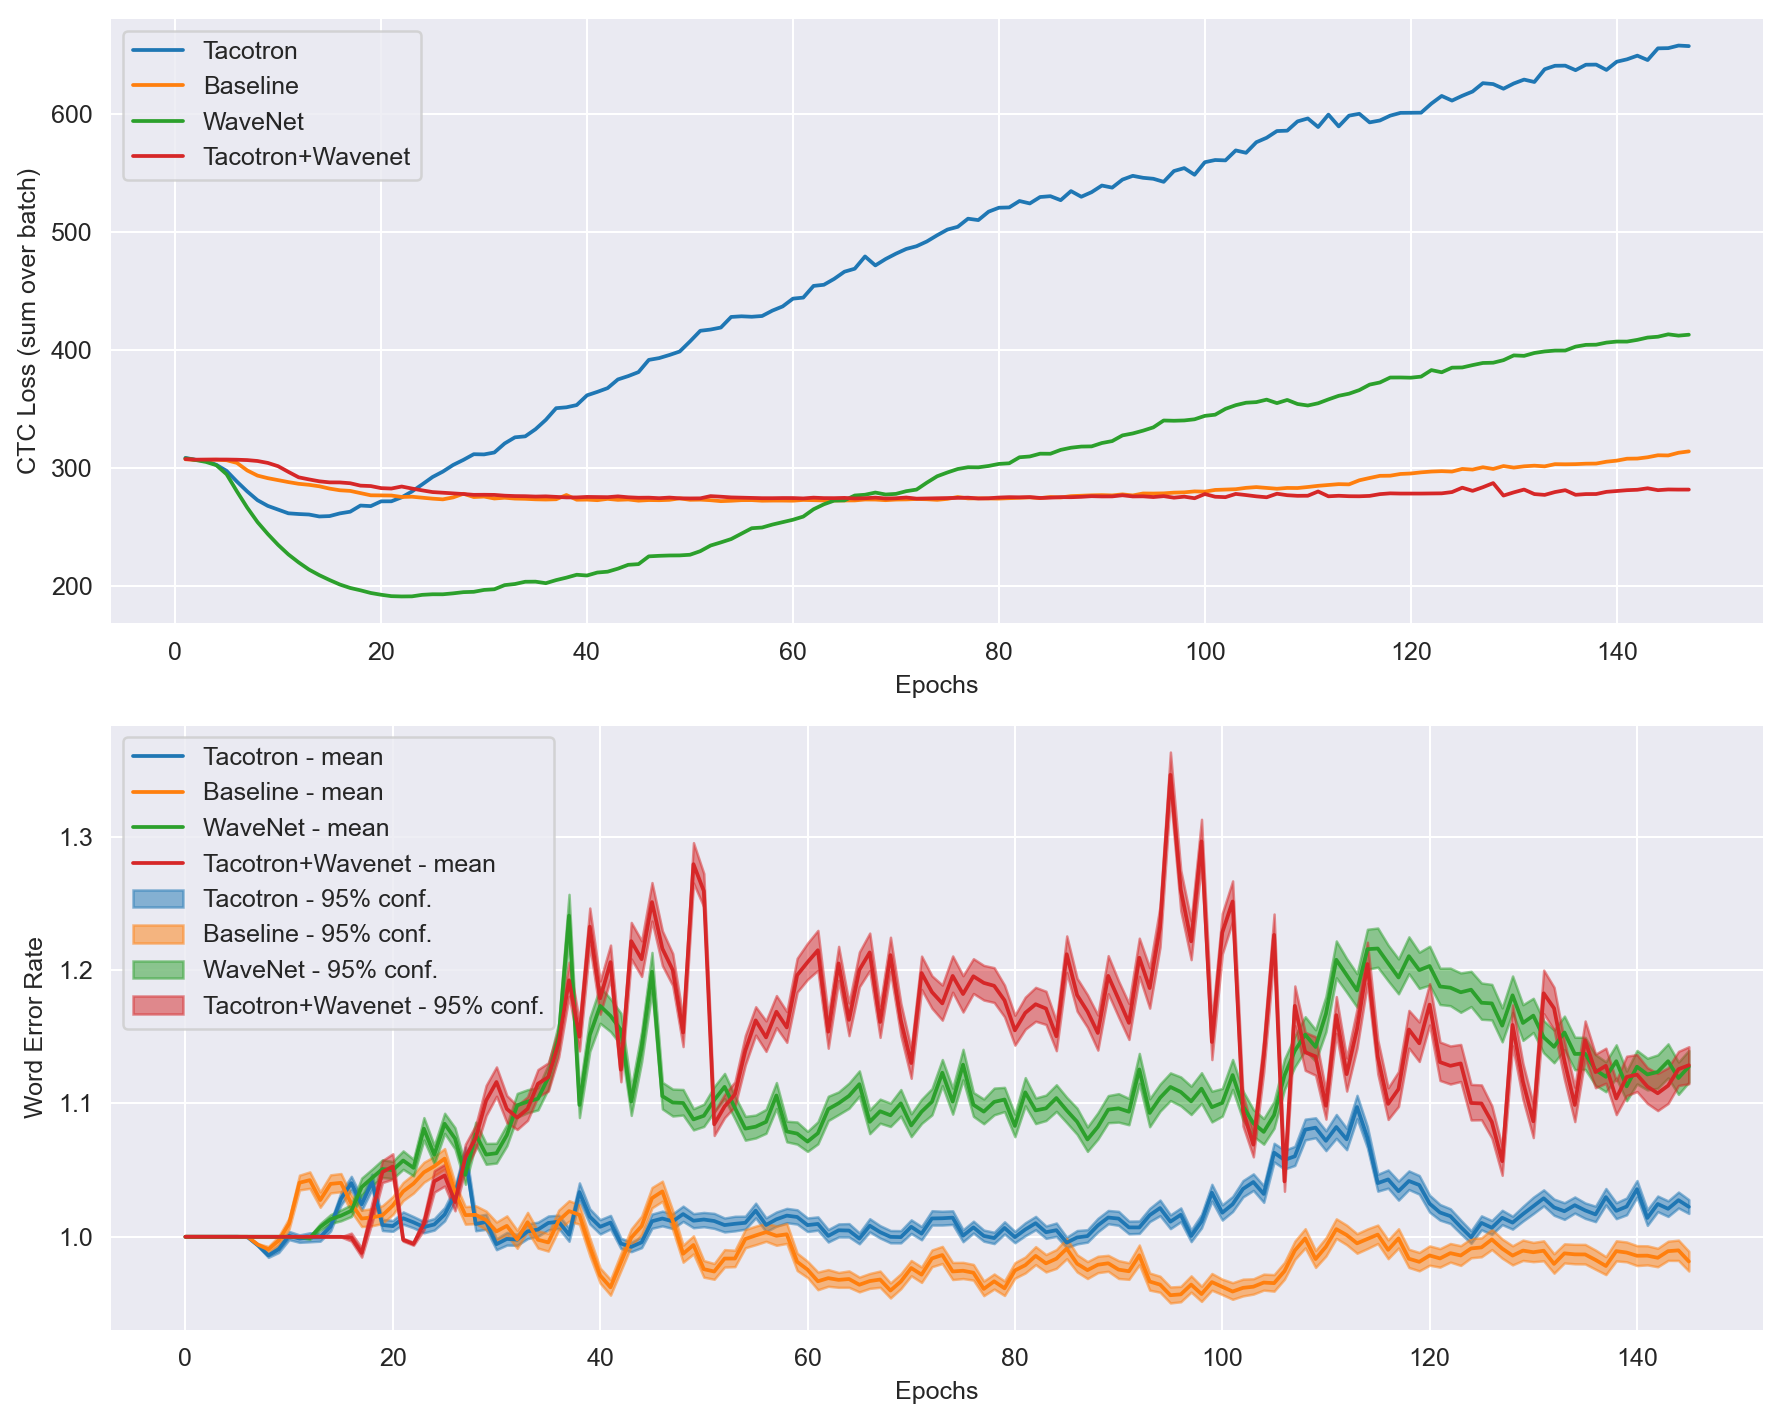

In [11]:
# Plots
fig, axs = plt.subplots(2,1,dpi=180,figsize=(10, 8))
mapping = {"Tacotron":(df_tc2_epoch,colors_hex.blue), 
           "Baseline":(df_wavenet_epoch,colors_hex.orange), 
           "WaveNet":(df_base_epoch,colors_hex.green),
           "Tacotron+Wavenet": (df_tc2_wavenet_epoch, colors_hex.red)}

for model in list(mapping.keys()):
    _,color = mapping[model]
    data = df[df["model_type"] == model].drop(columns=["model_type"]).to_numpy()

    xs = np.arange(len(data))

    mean, low, high = np.array(data)[:,0], np.array(data)[:,1], np.array(data)[:,2]

    axs[1].plot(mean, color=color, label=f'{model} - mean')
    plt.sca(axs[1]) # <-- makes gca work, super wierd but gets the job done
    plt.gca().fill_between(xs, high, low,  color=color, alpha=0.5, label=f'{model} - 95% conf.')
    axs[1].legend()

axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Word Error Rate")

for model in ["Tacotron", "Baseline", "WaveNet", "Tacotron+Wavenet"]:
    data, color = mapping[model]
    axs[0].plot(data[:147], color=color, label=f'{model}')
    axs[0].legend()
    
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("CTC Loss (sum over batch)")

plt.tight_layout()

plt.savefig("./bootstrap_wer.pdf", dpi = 180, bbox_inches = 'tight')

CER one-sample non-parametric bootstrapping confidence intervals for all epochs:

In [12]:
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

# Bootstrap
df =  pd.DataFrame( np.ones((147*4, 4)), columns=["model_type", "mean", "low", "high"])
i = 0

for epoch in tqdm(range(1, 147)):
    mapping = {"Tacotron": df_tc2.loc[ df_tc2.epoch == epoch, "CER_rate"],
               "Baseline": df_base.loc[ df_base.epoch == epoch, "CER_rate"],
               "WaveNet": df_wavenet.loc[ df_wavenet.epoch == epoch, "CER_rate"],
               "Tacotron+Wavenet": df_tc2_wavenet.loc[ df_tc2_wavenet.epoch == epoch, "CER_rate"]}
    
    for model in list(mapping.keys()):
        wer = mapping[model]
        data = [ wer.sample(2703, replace=True).mean() for _ in range(1000) ]
        df.iloc[i] = model, np.mean(data), np.quantile(data, 0.025), np.quantile(data, 0.975)
        i += 1

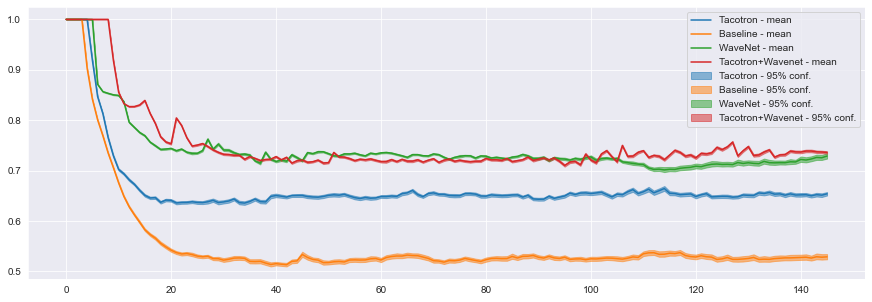

<Figure size 432x288 with 0 Axes>

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

mapping = {"Tacotron":(df_tc2_epoch,colors_hex.blue), 
           "Baseline":(df_wavenet_epoch,colors_hex.orange), 
           "WaveNet":(df_base_epoch,colors_hex.green),
           "Tacotron+Wavenet": (df_tc2_wavenet_epoch, colors_hex.red)}

for model in list(mapping.keys()):
    _ , color = mapping[model]
    data = df[df["model_type"] == model ].drop(columns=["model_type"]).to_numpy()

    xs = np.arange(len(data))

    mean, low, high = np.array(data)[:,0], np.array(data)[:,1], np.array(data)[:,2]

    ax.plot(mean, color=color, label=f'{model} - mean')
    plt.sca(ax) # <-- makes gca work, super wierd but gets the job done
    plt.gca().fill_between(xs, high, low,  color=color, alpha=0.5, label=f'{model} - 95% conf.')
    ax.legend()
    
plt.show()

plt.savefig("./bootstrap_cer.pdf", dpi = 180, bbox_inches = 'tight')

# Paired two-sample t-test:

In [14]:
def one_sample_t_test1(data,rows):
    diffs = data[rows[0]].reset_index(drop=True) - data[rows[1]].reset_index(drop=True)            
    stats = st.ttest_1samp(diffs, 0)
    
    return stats 
                  
# Test: WER
p1 = one_sample_t_test1(list1,[0,1])[1]
p2 = one_sample_t_test1(list1,[0,2])[1]
p3 = one_sample_t_test1(list1,[0,3])[1]
p4 = one_sample_t_test1(list1,[1,2])[1]
p5 = one_sample_t_test1(list1,[1,3])[1]
p6 = one_sample_t_test1(list1,[2,3])[1]

# Test: CER
p7 = one_sample_t_test1(list2,[0,1])[1]
p8 = one_sample_t_test1(list2,[0,2])[1]
p9 = one_sample_t_test1(list2,[0,3])[1]
p10 = one_sample_t_test1(list2,[1,2])[1]
p11 = one_sample_t_test1(list2,[1,3])[1]
p12 = one_sample_t_test1(list2,[2,3])[1]

# Bonferroni correct p-values 
numb_comparisons = 6
pvals1 = np.array([p1,p2,p3,p4,p5,p6]) * numb_comparisons 
pvals2 = np.array([p7,p8,p9,p10,p11,p12]) * numb_comparisons 

for i in range(6):
    print("p-value {}: {}".format(i,pvals1[i]))
for i in range(6):
    print("p-value {}: {}".format(i,pvals2[i]))

p-value 0: 2.738232601564612e-117
p-value 1: 1.4991593995430386e-89
p-value 2: 1.517224521795473e-189
p-value 3: 9.124689553456842e-15
p-value 4: 8.299071521152604e-16
p-value 5: 5.106942408429733e-79
p-value 0: 1.9505235345669175e-280
p-value 1: 0.0
p-value 2: 0.0
p-value 3: 0.0
p-value 4: 0.0
p-value 5: 2.86791431011219e-61


# One-sample t-test:

In [15]:
# Save data
def do_t_test(col='WER_rate'):
    WaveNet_conf = np.zeros((147,3))
    tc2_conf = np.zeros((147,3))
    base_conf = np.zeros((147,3))
    tc2_wavenet_conf = np.zeros((147,3))

    for i in range(1,147):
        # Calculate parameters
        X_wavenet = df_wavenet[col][df_wavenet['epoch'] == i]
        mean1 = np.mean(X_wavenet)
        scale1 = st.sem(X_wavenet)
        
        X_tc2 = df_tc2[col][df_tc2['epoch'] == i]
        mean2 = np.mean(X_tc2)
        scale2 = st.sem(X_tc2)
        
        X_base = df_base[col][df_base['epoch'] == i]
        mean3 = np.mean(X_base)
        scale3 = st.sem(X_base)
        
        X_tc2_wavenet = df_tc2_wavenet[col][df_tc2_wavenet['epoch'] == i]
        mean4 = np.mean(X_tc2_wavenet)
        scale4 = st.sem(X_tc2_wavenet)

        # Make t-tests 
        low1, up1 = st.t.interval(alpha=0.95, df=2703-1, loc=mean1, scale=scale1)
        low2, up2 = st.t.interval(alpha=0.95, df=2703-1, loc=mean2, scale=scale2)
        low3, up3 = st.t.interval(alpha=0.95, df=2703-1, loc=mean3, scale=scale3)
        low4, up4 = st.t.interval(alpha=0.95, df=2703-1, loc=mean4, scale=scale4)
        
        # Save data
        WaveNet_conf[i,:] = [mean1,low1,up1]
        tc2_conf[i,:] = [mean2,low2,up2]
        base_conf[i,:] = [mean3,low3,up3]
        tc2_wavenet_conf[i,:] = [mean4,low4,up4]
    return WaveNet_conf, tc2_conf, base_conf, tc2_wavenet_conf

In [16]:
WaveNet_conf_WER, tc2_conf_WER, base_conf_WER, tc2_wavenet_conf_WER = do_t_test(col='WER_rate')
WaveNet_conf_CER, tc2_conf_CER, base_conf_CER, tc2_wavenet_conf_CER = do_t_test(col='CER_rate')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in mult

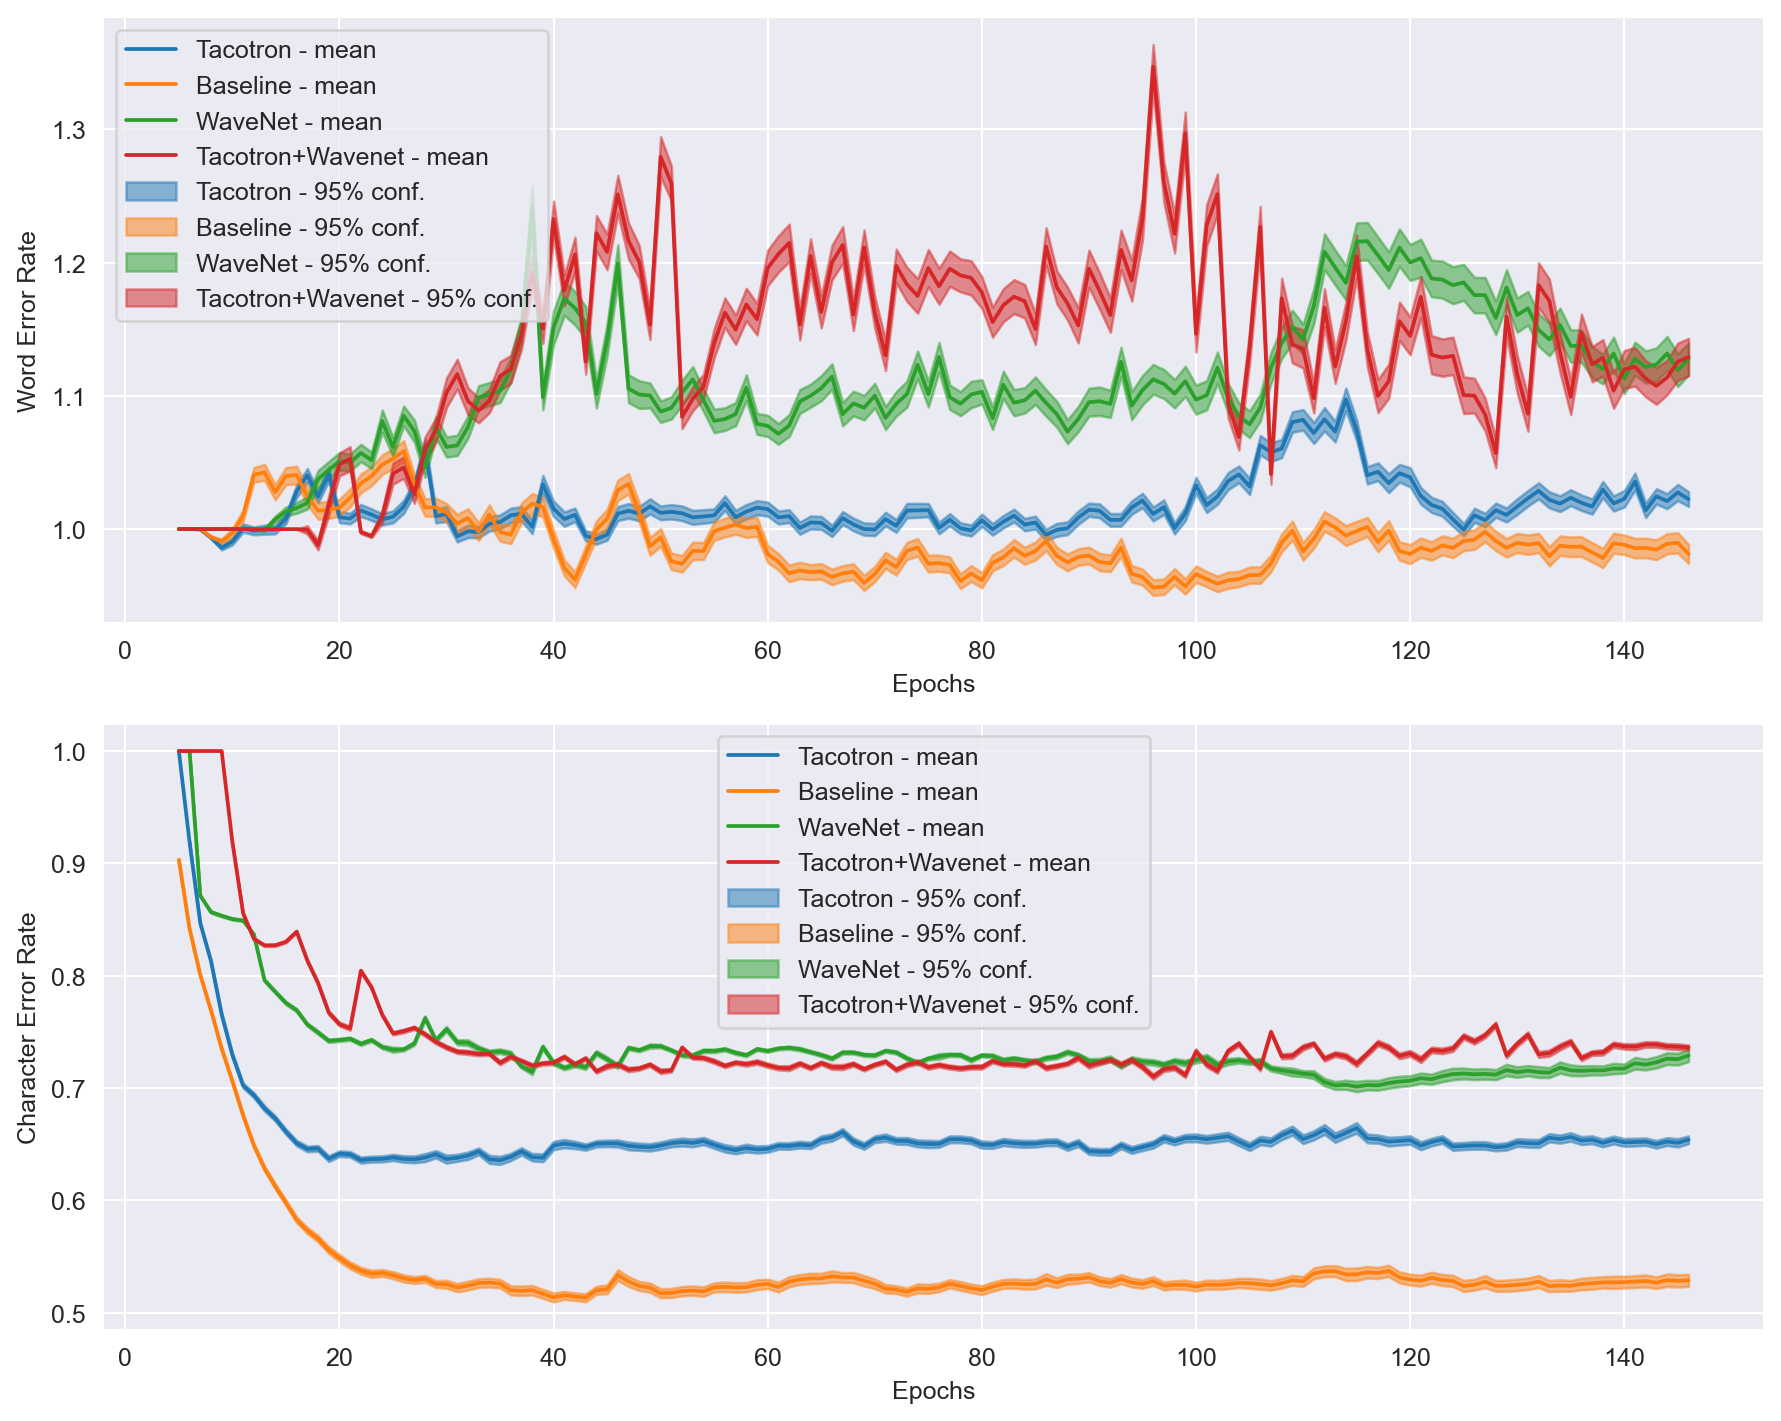

In [17]:
#plot

fig, axs = plt.subplots(2,1,dpi=180,figsize=(10, 8))

mapping1 = {"Tacotron":(tc2_conf_WER,colors_hex.blue), 
           "Baseline":(base_conf_WER,colors_hex.orange), 
           "WaveNet":(WaveNet_conf_WER,colors_hex.green),
           "Tacotron+Wavenet": (tc2_wavenet_conf_WER, colors_hex.red)}

mapping2 = {"Tacotron":(tc2_conf_CER,colors_hex.blue), 
           "Baseline":(base_conf_CER,colors_hex.orange), 
           "WaveNet":(WaveNet_conf_CER,colors_hex.green),
           "Tacotron+Wavenet": (tc2_wavenet_conf_CER, colors_hex.red)}

for ax, lab, mapping in zip(axs, ["Word Error Rate", "Character Error Rate"], [mapping1,mapping2]):
    for model in list(mapping.keys()):
        data , color = mapping[model]
        cutoff = 5
        xs = np.array(range(cutoff,len(data)))

        mean, low, high = data[cutoff:,0], data[cutoff:,1], data[cutoff:,2]

        ax.plot(xs,mean, color=color, label=f'{model} - mean')
        plt.sca(ax) # <-- makes gca work, super wierd but gets the job done
        plt.gca().fill_between(xs, high, low,  color=color, alpha=0.5, label=f'{model} - 95% conf.')
        ax.legend()
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel(lab)

plt.tight_layout()

plt.savefig("./t-test-statistic.pdf", dpi = 180, bbox_inches = 'tight')